# objective

Design model to predict seed yield

In [2]:
#load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder  
from sklearn.preprocessing import StandardScaler  
from scipy import sparse
from catboost import CatBoostRegressor
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import xgboost as xgb
from math import sqrt
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, randint
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV

/Users/edima/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
#load data
train = pd.read_csv('CC2020_train_final.csv')
test = pd.read_csv('CC2020_test_final.csv')

# Data Exploration

In [3]:
#check train
train.head()

,YEAR,LOCATION,INBRED,INBRED_CLUSTER,TESTER,TESTER_CLUSTER,YIELD
0,18,Loc 5608,Inbred_142,Cluster11,Tester_740,Cluster10,1.135462
1,18,Loc 4533,Inbred_142,Cluster11,Tester_740,Cluster10,1.139813
2,18,Loc 5620,Inbred_142,Cluster11,Tester_740,Cluster10,1.117778
3,18,Loc 4732,Inbred_142,Cluster11,Tester_740,Cluster10,1.171366
4,18,Loc 5500,Inbred_142,Cluster11,Tester_740,Cluster10,1.059364


In [4]:
#check test
test.head()

,INBRED,INBRED_CLUSTER,TESTER,TESTER_CLUSTER,YIELD
0,Inbred_1071,Cluster8,Tester_5450,Cluster5,NaN
1,Inbred_122,Cluster12,Tester_4336,Cluster6,NaN
2,Inbred_1337,Cluster17,Tester_2652,Cluster1,NaN
3,Inbred_1337,Cluster17,Tester_4373,Cluster3,NaN
4,Inbred_1339,Cluster17,Tester_4238,Cluster11,NaN


In [5]:
#get train summary
train.describe()

,YEAR,YIELD
count,199476.000000,199476.000000
mean,17.160551,1.001731
std,0.741779,0.104722
min,16.000000,0.047236
25%,17.000000,0.941870
50%,17.000000,1.003277
75%,18.000000,1.064073
max,18.000000,1.800083


In [6]:
#get test summary
test.describe()

,YIELD
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [8]:
#shapes
print("train shape")
print(train.shape)
print("test shape")
print(test.shape)

train shape
(199476, 7)
test shape
(1200, 5)


In [9]:
#check year column
train.YEAR.unique()

array([18, 17, 16])

In [10]:
#check location
train.LOCATION.unique()

array(['Loc 5608', 'Loc 4533', 'Loc 5620', 'Loc 4732', 'Loc 5500',
       'Loc 5514', 'Loc 4742', 'Loc 4625', 'Loc 4620', 'Loc 4524',
       'Loc 4442', 'Loc 4400', 'Loc 5420', 'Loc 4621', 'Loc 4601',
       'Loc 4532', 'Loc 4424', 'Loc 4341', 'Loc 4515', 'Loc 6609',
       'Loc 5424', 'Loc 5320', 'Loc 6415', 'Loc 4439', 'Loc 6730',
       'Loc 5330', 'Loc 5610', 'Loc 6700', 'Loc 6532', 'Loc 5711',
       'Loc 6634', 'Loc 6511', 'Loc 4623', 'Loc 4523', 'Loc 4Z23',
       'Loc 3631', 'Loc 3601', 'Loc 6418', 'Loc 6601', 'Loc 6614',
       'Loc 5511', 'Loc 4326', 'Loc 5324', 'Loc 4420', 'Loc 3437',
       'Loc 4401', 'Loc 3439', 'Loc 5336', 'Loc 7345', 'Loc 5340',
       'Loc 7319', 'Loc 6310', 'Loc 6421', 'Loc 7420', 'Loc 5240',
       'Loc 6320', 'Loc 8405', 'Loc 8316', 'Loc 7311', 'Loc 7612',
       'Loc 7332', 'Loc 7303', 'Loc 6734', 'Loc 7632', 'Loc 8320',
       'Loc 7243', 'Loc 8234', 'Loc 7440', 'Loc 7520', 'Loc 6334',
       'Loc 7727', 'Loc 7528', 'Loc 6719', 'Loc 7D06', 'Loc 73

In [11]:
#check INBRED
train.INBRED.unique()

array(['Inbred_142', 'Inbred_740', 'Inbred_743', 'Inbred_19',
       'Inbred_755', 'Inbred_737', 'Inbred_733', 'Inbred_739',
       'Inbred_754', 'Inbred_748', 'Inbred_750', 'Inbred_727',
       'Inbred_753', 'Inbred_586', 'Inbred_752', 'Inbred_736',
       'Inbred_749', 'Inbred_725', 'Inbred_761', 'Inbred_756',
       'Inbred_760', 'Inbred_757', 'Inbred_768', 'Inbred_765',
       'Inbred_764', 'Inbred_769', 'Inbred_759', 'Inbred_741',
       'Inbred_747', 'Inbred_745', 'Inbred_731', 'Inbred_773',
       'Inbred_738', 'Inbred_145', 'Inbred_777', 'Inbred_804',
       'Inbred_724', 'Inbred_122', 'Inbred_799', 'Inbred_803',
       'Inbred_732', 'Inbred_801', 'Inbred_800', 'Inbred_770',
       'Inbred_805', 'Inbred_751', 'Inbred_771', 'Inbred_744',
       'Inbred_790', 'Inbred_746', 'Inbred_1339', 'Inbred_789',
       'Inbred_1071', 'Inbred_1342', 'Inbred_1345', 'Inbred_1341',
       'Inbred_1346', 'Inbred_1340', 'Inbred_1349', 'Inbred_1360',
       'Inbred_1358', 'Inbred_1354', 'Inbred_13

In [12]:
#Inbred cluster
train.INBRED_CLUSTER.unique()

array(['Cluster11', 'Cluster10', 'Cluster12', 'Cluster8', 'Cluster17',
       'Cluster5', 'Cluster1', 'Cluster4', 'Cluster7', 'Cluster3',
       'Cluster14', 'Cluster6', 'Cluster9', 'Cluster2'], dtype=object)

In [13]:
#Tester information
train.TESTER.unique()

array(['Tester_740', 'Tester_743', 'Tester_757', 'Tester_761',
       'Tester_767', 'Tester_775', 'Tester_776', 'Tester_779',
       'Tester_789', 'Tester_793', 'Tester_813', 'Tester_819',
       'Tester_821', 'Tester_828', 'Tester_829', 'Tester_1345',
       'Tester_1349', 'Tester_1397', 'Tester_2636', 'Tester_2652',
       'Tester_2683', 'Tester_2689', 'Tester_2690', 'Tester_2721',
       'Tester_2724', 'Tester_2736', 'Tester_2747', 'Tester_2773',
       'Tester_3404', 'Tester_3440', 'Tester_3484', 'Tester_3485',
       'Tester_3504', 'Tester_3507', 'Tester_3521', 'Tester_3565',
       'Tester_3567', 'Tester_3573', 'Tester_3577', 'Tester_3582',
       'Tester_3791', 'Tester_3796', 'Tester_4025', 'Tester_4048',
       'Tester_4051', 'Tester_4059', 'Tester_4062', 'Tester_4063',
       'Tester_4065', 'Tester_4067', 'Tester_4072', 'Tester_4082',
       'Tester_4083', 'Tester_4097', 'Tester_4099', 'Tester_4102',
       'Tester_4115', 'Tester_4119', 'Tester_4131', 'Tester_4135',
       'Te

In [14]:
#TESTER_CLUSTER
train.TESTER_CLUSTER.unique()

array(['Cluster10', 'Cluster5', 'Cluster4', 'Cluster8', 'Cluster17',
       'Cluster11', 'Cluster1', 'Cluster3', 'Cluster7', 'Cluster12',
       'Cluster6', 'Cluster14', 'Cluster2'], dtype=object)

In [15]:
#Yield information
train.YIELD.unique()

array([1.13546205, 1.13981255, 1.1177782 , ..., 0.97258388, 0.90014022,
       0.95307504])

# Data visualization

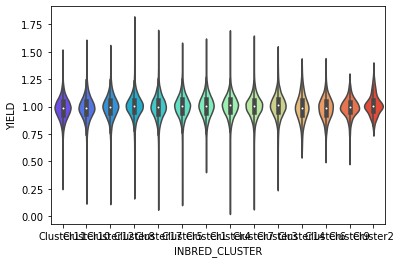

In [17]:
#inbred cluster and yield
sns.violinplot(x="INBRED_CLUSTER", y="YIELD", data=train,palette='rainbow')

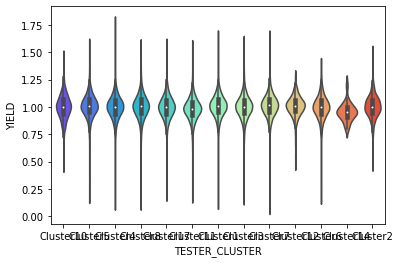

In [18]:
#tester cluster
sns.violinplot(x="TESTER_CLUSTER", y="YIELD", data=train,palette='rainbow')

In [ ]:
#count tester cluster
#frequency distribtion of TESTER CLUSTER
sns.countplot(data = train, x = 'TESTER_CLUSTER')

In [ ]:
#count inbreed cluster
#frequency distribtion of inbred CLUSTER
sns.countplot(data = train, x = 'INBRED_CLUSTER')

In [7]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [8]:
def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [9]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

In [1]:
#!pip install dython

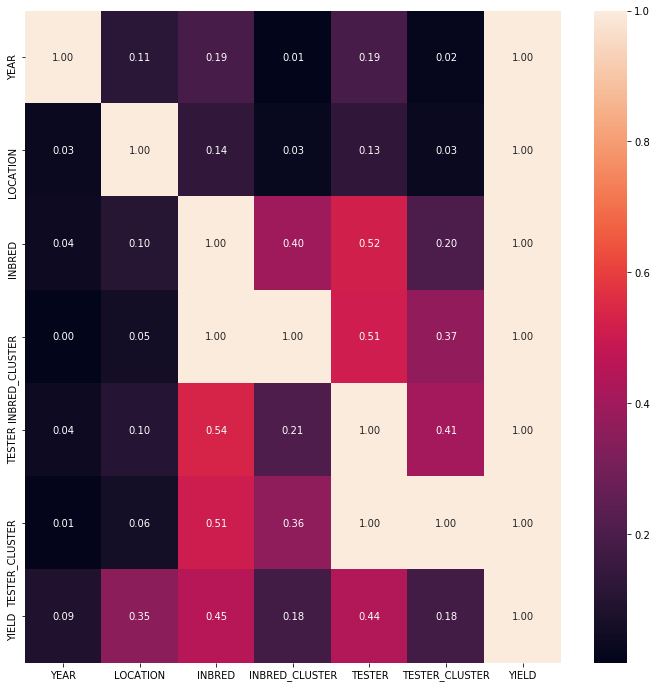

In [33]:
import dython
from dython import nominal
#associations_example()
nominal.associations(train, theil_u=True, nominal_columns='all', figsize=(12,12))

# Data modeling

In [4]:
#check for missing data
train.isnull().sum()

YEAR              0
LOCATION          0
INBRED            0
INBRED_CLUSTER    0
TESTER            0
TESTER_CLUSTER    0
YIELD             0
dtype: int64

In [5]:
categorical = ["LOCATION",'INBRED','INBRED_CLUSTER','TESTER','TESTER_CLUSTER']

In [34]:
#hyper parameter tuning
#!pip install hyperopt

In [6]:
from hyperopt import hp
import numpy as np
from sklearn.metrics import mean_squared_error


# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}
xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# LightGBM parameters
lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}
lgb_fit_params = {
    'eval_metric': 'l2',
    'early_stopping_rounds': 10,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# CatBoost parameters
ctb_reg_params = {
    'learning_rate':     hp.choice('learning_rate',     np.arange(0.05, 0.31, 0.05)),
    'max_depth':         hp.choice('max_depth',         np.arange(5, 16, 1, dtype=int)),
    'colsample_bylevel': hp.choice('colsample_bylevel', np.arange(0.3, 0.8, 0.1)),
    'n_estimators':      100,
    'eval_metric':       'RMSE',
}
ctb_fit_params = {
    'early_stopping_rounds': 10,
    'verbose': False
}
ctb_para = dict()
ctb_para['reg_params'] = ctb_reg_params
ctb_para['fit_params'] = ctb_fit_params
ctb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [17]:
import lightgbm as lgb
import xgboost as xgb
import catboost as ctb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials


class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def ctb_reg(self, para):
        reg = ctb.CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [ ]:
#obj = HPOpt(x_train, x_test, y_train, y_test)

#xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)
#lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)
#ctb_opt = obj.process(fn_name='ctb_reg', space=ctb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

In [7]:
#Create new training and test dataset
df_train = train[train['YEAR']<18]
df_test = train[train['YEAR']==18]

In [8]:
#drop the YEAR column in new train and test data
df_train_cat = df_train.drop(['YEAR'], axis=1)
df_test_cat = df_test.drop(['YEAR'], axis=1)

In [ ]:
# Catboost model

# cat boost model 1

In [9]:
#split training data set
X_train1 = df_train_cat.drop(['YIELD'], axis=1)
y_train1 = df_train_cat.YIELD

#split test dataset
X_test1 = df_test_cat.drop(['YIELD'], axis=1)
y_test1 = df_test_cat.YIELD

def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, query_cols, sorter=sidx)]

categorical_features_indices = column_index(X_train1, categorical)
categorical_features_indices1 = column_index(X_test1, categorical)


model=CatBoostRegressor(iterations=500, depth=10, learning_rate=0.01, loss_function='RMSE')

In [11]:
model.fit(X_train1, y_train1,cat_features=categorical_features_indices,eval_set=(X_test1, y_test1),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1013579	test: 0.1101568	best: 0.1101568 (0)	total: 380ms	remaining: 3m 9s
1:	learn: 0.1013005	test: 0.1101445	best: 0.1101445 (1)	total: 721ms	remaining: 2m 59s
2:	learn: 0.1012433	test: 0.1101323	best: 0.1101323 (2)	total: 1.07s	remaining: 2m 57s
3:	learn: 0.1011651	test: 0.1101191	best: 0.1101191 (3)	total: 1.34s	remaining: 2m 46s
4:	learn: 0.1010897	test: 0.1101098	best: 0.1101098 (4)	total: 1.5s	remaining: 2m 28s
5:	learn: 0.1010134	test: 0.1101003	best: 0.1101003 (5)	total: 1.67s	remaining: 2m 17s
6:	learn: 0.1009395	test: 0.1100918	best: 0.1100918 (6)	total: 2.09s	remaining: 2m 27s
7:	learn: 0.1008669	test: 0.1100827	best: 0.1100827 (7)	total: 2.64s	remaining: 2m 42s
8:	learn: 0.1007967	test: 0.1100721	best: 0.1100721 (8)	total: 2.81s	remaining: 2m 33s
9:	learn: 0.1007248	test: 0.1100631	best: 0.1100631 (9)	total: 3.05s	remaining: 2m 29s
10:	learn: 0.1006537	test: 0.1100548	best: 0.1100548 (10)	total: 3.25s	remaining: 2m 24s
11:	learn: 0.1005846	test: 0.1100476	best: 

94:	learn: 0.0970575	test: 0.1099229	best: 0.1098724 (59)	total: 14.9s	remaining: 1m 3s
95:	learn: 0.0970309	test: 0.1099253	best: 0.1098724 (59)	total: 15s	remaining: 1m 3s
96:	learn: 0.0970066	test: 0.1099301	best: 0.1098724 (59)	total: 15.1s	remaining: 1m 2s
97:	learn: 0.0969832	test: 0.1099337	best: 0.1098724 (59)	total: 15.2s	remaining: 1m 2s
98:	learn: 0.0969581	test: 0.1099377	best: 0.1098724 (59)	total: 15.4s	remaining: 1m 2s
99:	learn: 0.0969341	test: 0.1099389	best: 0.1098724 (59)	total: 15.6s	remaining: 1m 2s
100:	learn: 0.0969086	test: 0.1099404	best: 0.1098724 (59)	total: 15.8s	remaining: 1m 2s
101:	learn: 0.0968844	test: 0.1099422	best: 0.1098724 (59)	total: 15.9s	remaining: 1m 2s
102:	learn: 0.0968624	test: 0.1099454	best: 0.1098724 (59)	total: 16s	remaining: 1m 1s
103:	learn: 0.0968393	test: 0.1099468	best: 0.1098724 (59)	total: 16.2s	remaining: 1m 1s
104:	learn: 0.0968171	test: 0.1099513	best: 0.1098724 (59)	total: 16.3s	remaining: 1m 1s
105:	learn: 0.0967943	test: 0.1

187:	learn: 0.0956452	test: 0.1102691	best: 0.1098724 (59)	total: 28.4s	remaining: 47.1s
188:	learn: 0.0956353	test: 0.1102715	best: 0.1098724 (59)	total: 28.5s	remaining: 46.9s
189:	learn: 0.0956282	test: 0.1102772	best: 0.1098724 (59)	total: 28.6s	remaining: 46.7s
190:	learn: 0.0956189	test: 0.1102817	best: 0.1098724 (59)	total: 28.7s	remaining: 46.5s
191:	learn: 0.0956082	test: 0.1102869	best: 0.1098724 (59)	total: 28.8s	remaining: 46.2s
192:	learn: 0.0955980	test: 0.1102901	best: 0.1098724 (59)	total: 28.9s	remaining: 46s
193:	learn: 0.0955896	test: 0.1102950	best: 0.1098724 (59)	total: 29.2s	remaining: 46s
194:	learn: 0.0955821	test: 0.1103004	best: 0.1098724 (59)	total: 29.3s	remaining: 45.8s
195:	learn: 0.0955741	test: 0.1103046	best: 0.1098724 (59)	total: 29.4s	remaining: 45.6s
196:	learn: 0.0955649	test: 0.1103083	best: 0.1098724 (59)	total: 29.5s	remaining: 45.4s
197:	learn: 0.0955568	test: 0.1103105	best: 0.1098724 (59)	total: 29.6s	remaining: 45.2s
198:	learn: 0.0955498	tes

280:	learn: 0.0950445	test: 0.1105615	best: 0.1098724 (59)	total: 39.4s	remaining: 30.7s
281:	learn: 0.0950403	test: 0.1105637	best: 0.1098724 (59)	total: 39.5s	remaining: 30.6s
282:	learn: 0.0950370	test: 0.1105659	best: 0.1098724 (59)	total: 39.6s	remaining: 30.4s
283:	learn: 0.0950321	test: 0.1105667	best: 0.1098724 (59)	total: 39.7s	remaining: 30.2s
284:	learn: 0.0950283	test: 0.1105691	best: 0.1098724 (59)	total: 39.9s	remaining: 30.1s
285:	learn: 0.0950241	test: 0.1105710	best: 0.1098724 (59)	total: 40s	remaining: 29.9s
286:	learn: 0.0950203	test: 0.1105716	best: 0.1098724 (59)	total: 40.1s	remaining: 29.8s
287:	learn: 0.0950183	test: 0.1105739	best: 0.1098724 (59)	total: 40.2s	remaining: 29.6s
288:	learn: 0.0950135	test: 0.1105762	best: 0.1098724 (59)	total: 40.4s	remaining: 29.5s
289:	learn: 0.0950097	test: 0.1105782	best: 0.1098724 (59)	total: 40.5s	remaining: 29.3s
290:	learn: 0.0950039	test: 0.1105798	best: 0.1098724 (59)	total: 40.6s	remaining: 29.2s
291:	learn: 0.0949989	t

373:	learn: 0.0946887	test: 0.1107540	best: 0.1098724 (59)	total: 50.6s	remaining: 17s
374:	learn: 0.0946869	test: 0.1107546	best: 0.1098724 (59)	total: 50.7s	remaining: 16.9s
375:	learn: 0.0946840	test: 0.1107564	best: 0.1098724 (59)	total: 50.9s	remaining: 16.8s
376:	learn: 0.0946803	test: 0.1107573	best: 0.1098724 (59)	total: 51s	remaining: 16.6s
377:	learn: 0.0946768	test: 0.1107590	best: 0.1098724 (59)	total: 51.1s	remaining: 16.5s
378:	learn: 0.0946734	test: 0.1107614	best: 0.1098724 (59)	total: 51.2s	remaining: 16.4s
379:	learn: 0.0946722	test: 0.1107624	best: 0.1098724 (59)	total: 51.3s	remaining: 16.2s
380:	learn: 0.0946700	test: 0.1107643	best: 0.1098724 (59)	total: 51.5s	remaining: 16.1s
381:	learn: 0.0946674	test: 0.1107658	best: 0.1098724 (59)	total: 51.6s	remaining: 15.9s
382:	learn: 0.0946650	test: 0.1107690	best: 0.1098724 (59)	total: 51.7s	remaining: 15.8s
383:	learn: 0.0946613	test: 0.1107712	best: 0.1098724 (59)	total: 51.8s	remaining: 15.7s
384:	learn: 0.0946597	tes

466:	learn: 0.0944037	test: 0.1108800	best: 0.1098724 (59)	total: 1m 2s	remaining: 4.4s
467:	learn: 0.0944006	test: 0.1108815	best: 0.1098724 (59)	total: 1m 2s	remaining: 4.27s
468:	learn: 0.0943978	test: 0.1108817	best: 0.1098724 (59)	total: 1m 2s	remaining: 4.13s
469:	learn: 0.0943961	test: 0.1108832	best: 0.1098724 (59)	total: 1m 2s	remaining: 4s
470:	learn: 0.0943933	test: 0.1108864	best: 0.1098724 (59)	total: 1m 2s	remaining: 3.87s
471:	learn: 0.0943905	test: 0.1108880	best: 0.1098724 (59)	total: 1m 2s	remaining: 3.73s
472:	learn: 0.0943879	test: 0.1108877	best: 0.1098724 (59)	total: 1m 3s	remaining: 3.6s
473:	learn: 0.0943855	test: 0.1108894	best: 0.1098724 (59)	total: 1m 3s	remaining: 3.46s
474:	learn: 0.0943825	test: 0.1108905	best: 0.1098724 (59)	total: 1m 3s	remaining: 3.33s
475:	learn: 0.0943799	test: 0.1108912	best: 0.1098724 (59)	total: 1m 3s	remaining: 3.2s
476:	learn: 0.0943750	test: 0.1108927	best: 0.1098724 (59)	total: 1m 3s	remaining: 3.07s
477:	learn: 0.0943730	test:

In [12]:
#Catboost parameter tuning
model =  CatBoostRegressor(iterations=700,
                             learning_rate=0.01,
                             depth=16,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100)
model.fit(X_train1, y_train1,
                 eval_set=(X_test1, y_test1),
                 cat_features=categorical_features_indices,
                 use_best_model=True)

0:	learn: 0.1013148	test: 0.1101589	best: 0.1101589 (0)	total: 2.83s	remaining: 32m 59s
75:	learn: 0.0956545	test: 0.1098747	best: 0.1098519 (63)	total: 2m 31s	remaining: 20m 42s
150:	learn: 0.0920349	test: 0.1101296	best: 0.1098519 (63)	total: 5m 9s	remaining: 18m 43s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1098518569
bestIteration = 63

Shrink model to first 64 iterations.


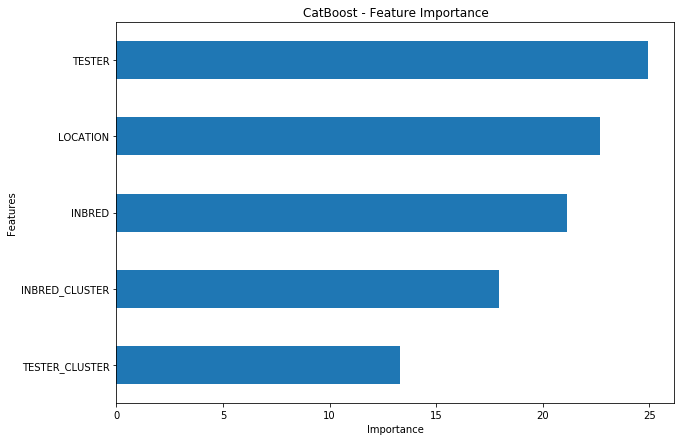

In [14]:
#Catboost feature importance
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X_train1.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

In [15]:
#build test prediction
predicted_cat = model.predict(X_test1)

In [18]:
#more parameter tuning
obj = HPOpt(X_train1, X_test1, y_train1, y_test1)
ctb_opt = obj.process(fn_name='ctb_reg', space=ctb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

  0%|          | 0/100 [00:00<?, ?it/s, best loss: ?]


# Light GBM Model 1

In [35]:
train = pd.read_csv('CC2020_train_final.csv')
test = pd.read_csv('CC2020_test_final.csv')

In [19]:
#Create new training and test dataset
df_train = train[train['YEAR']<18]
df_test = train[train['YEAR']==18]

In [20]:
#drop the YEAR, LOCATION column in new train and test data
df_train1 = df_train.drop(['YEAR','LOCATION'], axis=1)
df_test1 = df_test.drop(['YEAR','LOCATION'], axis=1)

In [21]:
#drop the YEAR, LOCATION column in new train and test data
df_train = df_train.drop(['YEAR','LOCATION'], axis=1)
df_test = df_test.drop(['YEAR','LOCATION'], axis=1)

In [22]:
categorical = ['INBRED','INBRED_CLUSTER','TESTER','TESTER_CLUSTER']
label_encoder = preprocessing.LabelEncoder()
for col in categorical:
    df_train1[col] = label_encoder.fit_transform(df_train1[col].astype(str))
    df_test1[col] = label_encoder.fit_transform(df_test1[col].astype(str))


In [23]:
#split training data set
X_train2 = df_train1.drop(['YIELD'], axis=1)
y_train2 = df_train1.YIELD

#split test dataset
X_test2 = df_test1.drop(['YIELD'], axis=1)
y_test2 = df_test1.YIELD

In [24]:
X = df_train.loc[:, df_train.columns != 'YIELD']
feature_names = X.columns.tolist()

In [25]:
# LightGBM dataset formatting 
lgtrain = lgb.Dataset(X_train2, y_train2,
                feature_name=feature_names,
                categorical_feature = categorical)
lgvalid = lgb.Dataset(X_test2, y_test2,
                feature_name=feature_names,
                categorical_feature = categorical)

In [26]:
params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'num_leaves' : 200,
    'max_depth': 15,
    'learning_rate' : 0.01,
    'feature_fraction' : 0.6,
    'verbosity' : -1
}

lgb_clf = lgb.train(
    params,
    lgtrain,
    20000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train', 'test'],
    early_stopping_rounds=500,
    verbose_eval=500
)

Training until validation scores don't improve for 500 rounds
[500]	train's rmse: 0.0964248	test's rmse: 0.115267
Early stopping, best iteration is:
[19]	train's rmse: 0.100491	test's rmse: 0.110106


In [27]:
from sklearn.metrics import mean_squared_error
print("RMSE of the validation set:", np.sqrt(mean_squared_error(y_test2, lgb_clf.predict(X_test2))))

RMSE of the validation set: 0.11010635056202028


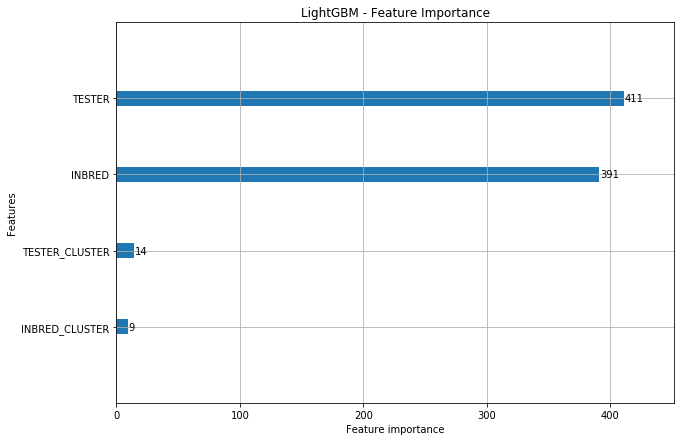

In [28]:
#feature importance
fig, ax = plt.subplots(figsize=(10, 7))
lgb.plot_importance(lgb_clf, max_num_features=30, ax=ax)
plt.title("LightGBM - Feature Importance");

In [29]:
# test prediction
prediction_light = lgb_clf.predict(X_test2)

In [30]:
obj = HPOpt(X_train2, X_test2, y_train2, y_test2)
lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

100%|██████████| 100/100 [00:39<00:00,  2.55it/s, best loss: 0.10973209046877926]


# XGBoost Model

In [48]:
train = pd.read_csv('CC2020_train_final.csv')
test = pd.read_csv('CC2020_test_final.csv')

In [32]:
#Create new training and test dataset
df_train = train[train['YEAR']<18]
df_test = train[train['YEAR']==18]

In [33]:
#drop the YEAR, LOCATION column in new train and test data
df_train2 = df_train.drop(['YEAR','LOCATION'], axis=1)
df_test2 = df_test.drop(['YEAR','LOCATION'], axis=1)

In [34]:
import xgboost as xgb
target_encode_columns = ['INBRED','TESTER','TESTER_CLUSTER','INBRED_CLUSTER']
target = ['YIELD']
target_encode_df = df_train2[target_encode_columns + target].reset_index().drop(columns = 'index', axis = 1)
target_name = target[0]
target_df = pd.DataFrame()
for embed_col in target_encode_columns:
    val_map = target_encode_df.groupby(embed_col)[target].mean().to_dict()[target_name]
    target_df[embed_col] = target_encode_df[embed_col].map(val_map).values
    
score_target_drop = df_train2.drop(target_encode_columns, axis = 1).reset_index().drop(columns = 'index', axis = 1)
score_target = pd.concat([score_target_drop, target_df], axis = 1)

In [35]:
score_target.head()

,YIELD,INBRED,TESTER,TESTER_CLUSTER,INBRED_CLUSTER
0,0.914693,1.014345,0.974859,1.001545,0.990321
1,0.947855,1.014345,0.974859,1.001545,0.990321
2,0.938258,1.014345,0.974859,1.001545,0.990321
3,1.037171,1.014345,0.974859,1.001545,0.990321
4,0.898236,1.014345,0.974859,1.001545,0.990321


In [36]:
target_encode_columns = ['INBRED','TESTER','TESTER_CLUSTER','INBRED_CLUSTER']
target = ['YIELD']
target_encode_df = df_test2[target_encode_columns + target].reset_index().drop(columns = 'index', axis = 1)
target_name = target[0]
target_df = pd.DataFrame()
for embed_col in target_encode_columns:
    val_map = target_encode_df.groupby(embed_col)[target].mean().to_dict()[target_name]
    target_df[embed_col] = target_encode_df[embed_col].map(val_map).values
    
score_target_drop = df_test2.drop(target_encode_columns, axis = 1).reset_index().drop(columns = 'index', axis = 1)
score_test = pd.concat([score_target_drop, target_df], axis = 1)

In [37]:
#split training data set
X_train3 = score_target.drop(['YIELD'], axis=1)
y_train3 = score_target.YIELD

#split test dataset
X_test3 = score_test.drop(['YIELD'], axis=1)
y_test3 = score_test.YIELD

In [38]:
params = {'colsample_bytree': uniform(0.7, 0.3),
          'gamma': uniform(0, 0.5),
          'learning_rate': uniform(0.003, 0.3), # default 0.1 
          'max_depth': randint(2, 6), # default 3
          'n_estimators': randint(100, 250), # default 100
          'subsample': uniform(0.6, 0.4)}
xgb_model = xgb.XGBRegressor(objective="reg:linear",random_state=42)
time_split = TimeSeriesSplit(n_splits = 8)
xgb_search = RandomizedSearchCV(xgb_model,param_distributions=params, 
                                random_state=42, n_iter=4, cv=time_split, 
                                verbose=1, n_jobs=1, return_train_score=True)

In [40]:
xgb_search.fit(X_train3, y_train3)

Fitting 8 folds for each of 4 candidates, totalling 32 fits
[15:29:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[15:29:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  2.6min finished


[15:31:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=8),
                   error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2eb3b278>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2eb3b668>,
      

In [41]:
predicted_xgb = xgb_search.predict(X_test3)
rms = sqrt(mean_squared_error(y_test3, predicted_xgb ))
print ('RMSE:', rms)

RMSE: 0.104248887562759


In [ ]:
#feature importance
#import matplotlib.pyplot as plt
#xgb.plot_tree(xg_reg,num_trees=0)
#plt.rcParams['figure.figsize'] = [50, 10]
#plt.show()

In [ ]:
#https://medium.com/@songxia.sophia/two-machine-learning-algorithms-to-predict-xgboost-neural-network-with-entity-embedding-caac68717dea

In [ ]:
# Parameter tuning

In [43]:
obj = HPOpt(X_train3, X_test3, y_train3, y_test3)
xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

[15:36:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:36:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:36:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:36:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:36:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:36:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:36:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:36:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:36:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

# Ensemble Model

In [48]:
ensemble_preds_70_30_00 = 0.7 * prediction_light + 0.3 * predicted_cat + 0.0 * predicted_xgb 
ensemble_preds_70_25_05 = 0.7 * prediction_light + 0.25 * predicted_cat + 0.05 * predicted_xgb 
ensemble_preds_00_20_80 = 0.0 * prediction_light + 0.20 * predicted_cat + 0.80 * predicted_xgb 
ensemble_preds_05_25_70 = 0.05 * prediction_light + 0.25 * predicted_cat + 0.70 * predicted_xgb 

In [49]:
#convert to pandas dataframe
ensemble_preds_70_30_00_df = pd.Series(ensemble_preds_70_30_00)
ensemble_preds_70_25_05_df = pd.Series(ensemble_preds_70_25_05)
ensemble_preds_00_20_80_df = pd.Series(ensemble_preds_00_20_80)
ensemble_preds_05_25_70_df = pd.Series(ensemble_preds_05_25_70)

In [50]:
ensemble_preds_70_30_00_df.head()

0    1.007828
1    1.007164
2    1.007396
3    1.006697
4    1.007202
dtype: float64

# recommendation models

In [89]:
#!pip install turicreate

In [88]:
import turicreate

In [90]:
train = pd.read_csv('CC2020_train_final.csv')
test = pd.read_csv('CC2020_test_final.csv')

#Create new training and test dataset
df_train = train[train['YEAR']<18]
df_test = train[train['YEAR']==18]

#drop the YEAR, LOCATION column in new train and test data
df_train4 = df_train.drop(['YEAR','LOCATION'], axis=1)
df_test4 = df_test.drop(['YEAR','LOCATION'], axis=1)

In [91]:
train_data = turicreate.SFrame(df_train4)
test_data = turicreate.Sframe(df_test4)

AttributeError: module 'turicreate' has no attribute 'Sframe'